Too Short; Want More?
# ユーチューブの動画を使って感情認識を行う長編ノートブック

筑波大学情報科学類４年スコットアトム [HP](http://atomscott.com/)

![あとでかっこいい画像に変える](./pics/front_cover_tmp.png)

<hr>

メインに次のライブラリを使う！

In [1]:
import sys,os,importlib
import time

import dlib
import face_recognition
import chainer
import chainercv

import numpy as np
import matplotlib.pyplot as plt
import my_utils as utls # 自分のコード


<hr>

## 目次

### 背景
- **既存の感情認識の方法**
    - 表情
        - Face Detection
            - HOG + linear classifier + image pyramid + sliding window 
            - SSD + ResNet10
            - FasterRCNNVGG16のFine Tune 
        - Face Landmark Detection
        - Facial Emotion Recognition
    - 声色
    - その他
    

- **なぜデータセットを作る必要なのか** 
    - 既存のデータセットの概要
    - 日本語データセットを作ることの意義


### データセットの作成
- **対象人物の顔の辞書データを作成**
    - Web Scraping 対象人物の写真を集める　
    - Face Detection + ROI Cropping 写真の中から顔の写真を切り出す
    - Purification 対象人物以外の写真を除外する


- **対象人物の発話シーケンスを作成**
    - Web Scraping 対象人物の動画を集める
    - Scene Change Detection 動画をシーンごとに分ける
    - Face Recognition + ROI Cropping 辞書データをもとに対象人物の顔のみを切り出す
    - Active Speaker Verification
 
### Student - Teacher モデルで音声による感情認識モデルの作成
- **表情認識モデルの適用**

- **声色認識モデルの作成**

- **Ablation Study**

### 作成したモデルの検証

### ディスカッション・応用先の検討

### 最後に

*論文を書いたので読んでください！*

<hr>

## 背景

### 既存の感情認識の方法

#### 表情

人の感情を推定するときは表情が一番参考になる。よって、Facial Expression Recognition(FER)について多くの研究がなされており、様々なFERシステムが存在する。

日本では喜怒哀楽という四字熟語があり、感情を４つのカテゴリに分けることが主流なのかもしない。しかし、表情に関する研究の多くは：

- Anger
- Disgust
- Fear
- Happiness
- Sadness
- Suprise

のカテゴリに感情を分けているようだ。

一昔前までは、顔の特徴を記述するモデルとして[Facial Action Coding System(FACS)](https://www.paulekman.com/facial-action-coding-system/)が使用されていた。FACSは表情をアクションユニット（AU）と呼ばれる筋肉の動きの個々の要素に分解するモデルで、今でもアニメーションなどに使われているらしい。

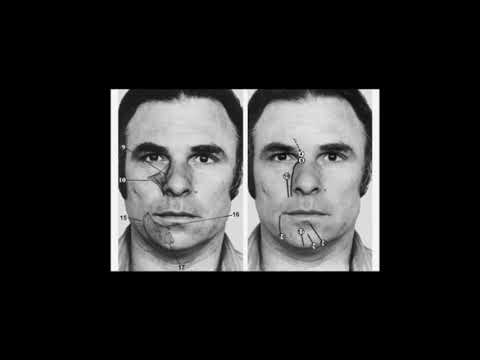

In [2]:
from IPython.display import Audio,Image, YouTubeVideo
YouTubeVideo(id='6RzCWRxnc84',width=600,height=300)

上にあげた動画に出てくるような理想的な状況下での顔面画像であれば、FACSは有効だが、"In the wild(野生の中で)"と呼ばれる状況、いわゆる普通のありふれた写真の感情認識は非常に難しい。

そもそも普通の写真ではどこに顔があるのかが分からない、あったとしても顔が正面を向いているとは限らないなど、多くの問題がある。

そのため、"In the wild"で表情認識を行う場合はFace Detection(顔認識)やFacial Alignmentと呼ばれる正規化などが前処理として必要になる。さらにFacial Alignmentを行うために顔のパーツ（鼻や目）を認識するFacial Landmark Detectionも行わなければならない。本当に大変である。

これらのハードルを乗り越えるために、近年ではCNNを用いたディープラーニングを用いた主流がメインになっている。それぞれについて詳細に説明すると本がかけしまうので、ここでは

- Face Detection
- Facial Landmark Detection

について、それぞれ一つのデータセットですぐに使えるモデルでどれだけの精度がでるのかを検証する。


**Face Detection**

検証用データセット : [WIDER FACE](http://shuoyang1213.me/WIDERFACE/WiderFace_Results.html)


![](./pics/wider.jpg)

WIDER FACEについて
>WIDER FACE dataset is a face detection benchmark dataset, of which images are selected from the publicly available WIDER dataset. We choose 32,203 images and label 393,703 faces with a high degree of variability in scale, pose and occlusion as depicted in the sample images. 

3万2203枚の画像・39万3703面の顔が含まれている。
（そう、このノートブックはガチなんやで）

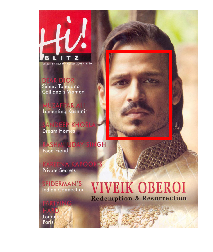

In [3]:
sys.path.append('./datasets/Wider_Face/')
from wider_face_dataset import WIDERFACEDataset

# Wider FaceのValidation用のデータ用意する
data_path = './datasets/Wider_Face/WIDER_val'
label_path = './datasets/Wider_Face/wider_face_split/wider_face_val.mat'
wider_face = WIDERFACEDataset(data_path, label_path)

# BBOX付きの写真は下のような感じ
img, bboxes, label = wider_face.get_example(320)
chainercv.visualizations.vis_bbox(img, bboxes)
plt.axis('off')
plt.show()

評価指標：Intersection over Union (IoU)に基づく「検出領域とアノテーション領域の交差の比率が0.5より大きい場合、スコアは１、それ以外の場合のスコアは0」という評価指標を用いる。

IoUの直感的なイメージ([src](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/))

![](./pics/iou.png)

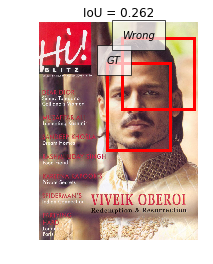

In [4]:
wrong_bbox = [[100., 535., 560., 1000.]] #自分でテキトーにBBOXを作る
iou_score = utls.get_iou(wrong_bbox[0], bboxes[0]) #IoUスコアを計算する

chainercv.visualizations.vis_bbox(img, np.append(bboxes, wrong_bbox, axis=0), label=[0,1], label_names=['GT', 'Wrong']) 
plt.title('IoU = {:.3f}'.format(iou_score))
plt.axis('off')
plt.show()

使用する顔認識のモデルは次の３つである。いずれも手軽ですぐにOut of the Boxで使えることを意識した。

- HOG Based
- CNN Based 
- FasterRCNNVGG16のFine Tune ([FasterRCNNVGG16](https://chainercv.readthedocs.io/en/stable/reference/links/faster_rcnn.html), [src](https://www.kaggle.com/mksaad/wider-face-a-face-detection-benchmark/version/4#WIDER_val.zip))

In [5]:
sys.path.append('./models/FasterRCNNVGG16_face_recognition/')
import FasterRCNNVGG16_face_recognition

sample_img = img.transpose(1,2,0).astype('uint8') #face_recognition用に配列順とtypeを変更

# HOG base & CNN baseのモデルface_recognitionモジュールからすぐに利用可能
HOG_out = face_recognition.face_locations(sample_img, number_of_times_to_upsample=0) # HOG baseの出力
CNN_out = face_recognition.face_locations(sample_img, number_of_times_to_upsample=0, model="cnn") # CNN baseの出力

# FasterRCNNVGG16ベースのモデルはモデルをダウンロードする必要がある
# その分面倒だが、chainerCVが使えてAIエンジニアっぽい！笑
TRAINED_MODEL = './models/FasterRCNNVGG16_face_recognition/snapshot_model_20180404.npz'

FRCNN_model = FasterRCNNVGG16_face_recognition.setup(TRAINED_MODEL)
# GPUを使わないといけないとMemory Errorになる可能性大！
FRCNN_out = FRCNN_model.predict([img])

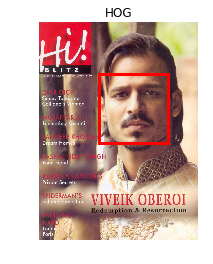

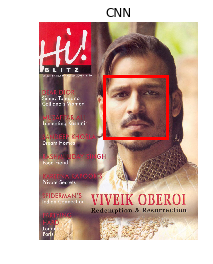

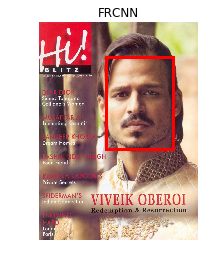

In [6]:
# サンプル出力
chainercv.visualizations.vis_bbox(img, HOG_out)
plt.title("HOG")
plt.axis('off')
plt.show()

chainercv.visualizations.vis_bbox(img, CNN_out)
plt.title("CNN")
plt.axis('off')
plt.show()

FRCNN_bbox = [list(map(int,FRCNN_out[0][0][0]))]
chainercv.visualizations.vis_bbox(img, FRCNN_bbox)
plt.title("FRCNN")
plt.axis('off')
plt.show()

GPUを使うといかにスピードアップするか知っとくといい気がするので、一度だけ比較実験しましょうか。

In [14]:
# CPU Speed
s = time.time()
FRCNN_model.to_cpu()
_ = FRCNN_model.predict([img])
print("CPU inference took: {:.3f} secs".format(time.time()-s))

# GPU Speed 
s = time.time()
FRCNN_model.to_gpu(0)
_ = FRCNN_model.predict([img])
print("GPU inference took: {:.3f} secs".format(time.time()-s))

CPU inference took: 10.111 secs
GPU inference took: 0.494 secs


結果

In [8]:
importlib.reload(utls)
test_iter = chainer.iterators.SerialIterator(wider_face, 1,repeat=False, shuffle=False)


total_faces = 0
HOG_score = 0
CNN_score = 0
for test_batch in test_iter:
    test_img = test_batch[0][0]
    test_bboxes = test_batch[0][1]

    HOG_out = face_recognition.face_locations(test_img.transpose(1,2,0).astype('uint8'), number_of_times_to_upsample=0)
    HOG_out = [(b[0], b[3], b[2], b[1]) for b in HOG_out] #(y1, x1, y2, x2)に形を直す

    CNN_out = face_recognition.face_locations(sample_img, number_of_times_to_upsample=0, model="cnn") # CNN baseの出力
    CNN_out = [(b[0], b[3], b[2], b[1]) for b in HOG_out] #(y1, x1, y2, x2)に形を直す
    
    total_faces += len(test_bboxes)
    HOG_score += utls.score_face_detection(HOG_out, test_bboxes)
    CNN_score += utls.score_face_detection(CNN_out, test_bboxes)
print(HOG_score, total_faces)

NameError: name 'face_recognition' is not defined

結果より、Wider Faceデータセットには群衆の写真など、顔認識を行うことが非常に難しいのが分かる。

Wider Faceデータセットを活用した、[Wider Challenge](http://wider-challenge.org/2019.html)というコンペが毎年、開催されており、2位になった[Insight Face](https://github.com/deepinsight/insightface_はFace DetectionとFacial Landmark Detectionの両方に関してState of the Artになっている。

手が回っていないが、ぜひいずれ実装したいと考えている。

**Facial Landmark Detection**
検証用データセット：[iBUG 300-W](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)

![](./pics/ibug.png)
(Fig 1.)

iBUG 300-Wについて
>The datasets LFPW, AFW, HELEN, and XM2VTS have been re-annotated using the mark-up of Fig 1. We provide additional annotations for another 135 images in difficult poses and expressions (IBUG training set). Annotations have the same name as the corresponding images. 

2万8827枚の写真に写っている顔に１面につき68点のラベルがアノテーションされている。

評価指標：目の端から端までの距離で顔の大きさを正規化してからの各点のユークリッド距離の平均

使用するモデル：

- One Millisecond Face Alignment with an Ensemble of Regression Trees by Vahid Kazemi and Josephine Sullivan ([paper](https://www.semanticscholar.org/paper/One-millisecond-face-alignment-with-an-ensemble-of-Kazemi-Sullivan/1824b1ccace464ba275ccc86619feaa89018c0ad) [src](http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html))
- resnet

手軽に使えるモデルが一つしか、見つからなかった。自分で軽く作ったモデルを入れている。

Face DetectionとFacial Landmark Recognitionについて、手軽なモデルを使ってどれくらいの精度が出るのかを理解したところで、次に表情認識についてより詳しく見てみよう。

以下が表情認識の一般的な流れだ。
![](./pics/face_pipeline.png)

表情認識には大きく分けて２つのタイプがある。

- Static Facial Emotion Recognition
    - 画像に対して表情認識を行う。
    
    
- Dynamic Facial Emotion Recognition
    - 動画に対して表情認識を行う。　

画像一枚に対して一つの感情を予測するStatic FERの方が、タスクとしてより簡単であること


**Facial Emotion Recognition**

検証用データセット: